## Load the necessary libraries

In [38]:
# data handling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.feature_selection import mutual_info_classif

# classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

# check package version in the end for better reproducibility
import session_info

## Import the data

In [3]:
# link to data: https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq
dataframe = pd.read_csv('cancer_gene_expression.zip')

## Data exploration and cleaning

In [4]:
# check the numbe of rows and columns (last column contains the labels)
# rows represent samples, columns represent features (except the last one)
print(dataframe.shape)

(801, 8001)


In [5]:
# check some of the columns
dataframe.columns[0:3]

Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')

In [6]:
# check the name of the last column
dataframe.columns[-1]

'Cancer_Type'

In [7]:
# check for missing values
datanul = dataframe.isnull().sum()
g=[i for i in datanul if i>0]
print('Columns with missing values: %d'%len(g))

Columns with missing values: 0


In [8]:
# check how many different cancer types are there in the data
print(dataframe['Cancer_Type'].value_counts())

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


We can see that there are 5 different cancer types.

<Axes: xlabel='Cancer_Type'>

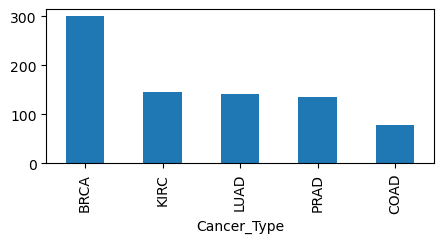

In [9]:
# barchart to display the cancer type distribution
dataframe['Cancer_Type'].value_counts().plot(kind='bar',figsize=(5,2))

## Data preprocessing
This is needed so the data are in a appropriate format before modelling

**1) Separate values from class**

In [10]:
# we first separate the values from the class (scikit requires it)
X = dataframe.iloc[:,0:-1]
y = dataframe.iloc[:,-1]

In [11]:
X.shape

(801, 8000)

In [12]:
y.shape

(801,)

**2) Encode the labels**

The labels for this dataset are categorical and therefore we have to convert them to numeric forms. This process is called 'encoding'. ML models usually require input data to be in numeric form.

In [13]:
# encode the labels (y) with values between 0 and n_classes-1 (using LabelEncoder)
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)

In [14]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [15]:
classes

array([0, 1, 2, 3, 4])

**3) Data splitting**

In this step the data are split into training and test subsets. The training data are then initially parsed to the ML model. This is done in order to enable the model to identify discriminatory patters which can be used to make future predictions. The testing data is used to evaluate the model after the training phase.

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size=0.2,random_state=42)

**4) Data normalization**

Data normalization is done so that the values are in the same range. This improves model performance and avoids bias.

In [17]:
# see that the data are not in the same ranges (differenct columns have different maximums)
dataframe.iloc[:,0:10].describe()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


In [18]:
# scale data between 0 and 1
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [19]:
# check a value before normalization
X_train.iloc[0,3]

2.18164326123

In [20]:
# check the same value after normalization (should be between 0 and 1)
X_train_norm[0,3]

0.4671305057022768

## Feature selection

The purpose of feature selection is about selecting relevant features for classification. Feature selection is usually done before the actual learning. In this script, the mutual information algorithm is used to compute the relevance of each feature. The top n (e.g. 300) features are selected for the ML analysis.

**Feature selection using Mutual Information**

In [21]:
MI = mutual_info_classif(X_train_norm,y_train)

In [22]:
# number of features
MI.shape

(8000,)

In [23]:
# first 5 (not sorted)
MI[0:5]

array([0.00791118, 0.05664001, 0.01235477, 0.05237047, 0.        ])

In [24]:
features = X_train.columns

In [25]:
features.shape

(8000,)

In [26]:
features[0:5]

Index(['gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5'], dtype='object')

In [27]:
# select top n features (you can play around the n value and see the model's performance)
n_features = 300
selected_scores_indices = np.argsort(MI)[::-1][0:n_features]
# np.argsort(MI) this means that we first sort the features 
# [::-1] then reverse so we have them from highest to lowest 
# [0:n_features] and the select the first 300

In [28]:
X_train_selected = X_train_norm[:,selected_scores_indices]
X_test_selected = X_test_norm[:,selected_scores_indices]

In [29]:
X_train_selected.shape 

(640, 300)

In [30]:
X_test_selected.shape

(161, 300)

## Classification

In this script, the random forest classifier is used because it works with multiclass and high dimensional data. Classification involves training and testing the model.
Info about the model: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**Model training**

Training allows the ML model to learn from the data and use the identified patterns to predict the outcomes of data it has never seen before.

In [31]:
# Random forest classifier 
# Because we are dealing with multiclass data, the one versus rest strategy is used.
# learn to predict each class against the other

RF = OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected,y_train) # we fit the train data together with their labels in the classifier = Supervised learning
y_pred = RF.predict(X_test_selected) # after training we make the predictions
pred_prob = RF.predict_proba(X_test_selected) # get probabilities for the classifier so we get the roc curves

**Model Evaluation**

After training the model, it is important to know how well the model performs on independent data (test data). We use the following metrics to evaluate the model:

- accuracy
- precision
- recall
- f1 score
- confusion matrix
- ROC Curve

In [32]:
# accuracy
accuracy = np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

# precision
precision = np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

# recall 
recall = np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

# f1score
f1score = np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score) 

report = classification_report(y_test,y_pred,target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9395
precision:0.9577
recall:0.9565
f1score:0.9564


classification report


              precision    recall  f1-score   support

        BRCA       0.94      0.98      0.96        60
        COAD       1.00      0.88      0.93        16
        KIRC       1.00      0.96      0.98        28
        LUAD       0.88      0.88      0.88        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.96       161
   macro avg       0.96      0.94      0.95       161
weighted avg       0.96      0.96      0.96       161



In [34]:
# generate confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm,index=labels,columns=labels)

In [35]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,59,0,0,1,0
COAD,0,14,0,2,0
KIRC,1,0,27,0,0
LUAD,3,0,0,21,0
PRAD,0,0,0,0,33


We can see on the above table that, for example, from the 60 cases of BRCA, 59 of them where predicted as BRCA by the model and 1 of them was wrongly predicted as LUAD.

Text(50.722222222222214, 0.5, 'True Labels')

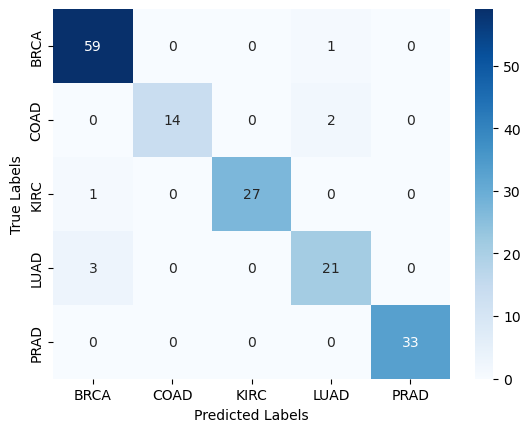

In [36]:
# visualize the confusion matrix
sns.heatmap(cm_df,annot=True,cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

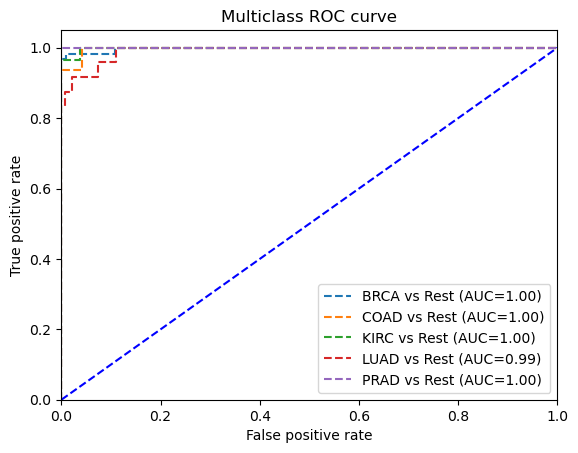

In [37]:
# roc curves will be generated for each class 
# we therefore have to binarize the y_test labels
# this is done because the probabilities (pred_prob) are calculated from each class
# we therefore need to transform the y_test label in the same format as the pred_prob
y_test_binarized = label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])
    
    # plotting
    plt.plot(fpr[i],tpr[i],linestyle='--',
            label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))
    
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()


In [39]:
session_info.show()